In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop


In [2]:
import os 
import zipfile
local_zip='/content/data.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
base_dir='/content/data'
train_dir= os.path.join(base_dir,'train')
validation_dir= os.path.join(base_dir,'test')

In [4]:
train_dir

'/content/data/train'

In [5]:
train_cats_dir = os.path.join(train_dir,'cloud')
train_dogs_dir = os.path.join(train_dir,'no_cloud/images')
validation_cats_dir=os.path.join(validation_dir,'cloud')
validation_dogs_dir=os.path.join(validation_dir,'no_cloud')

In [6]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [7]:
import matplotlib.image as mpimg

In [8]:
train_dog_fnames 



['images436.png',
 'images8.png',
 'images24.png',
 'A_132img.png',
 'A_178img.png',
 'A_121img.png',
 'A_159img.png',
 'images161.png',
 'A_170img.png',
 'A_4img.png',
 'A_20img.png',
 'images35.png',
 'images297.png',
 'A_19img.png',
 'A_143img.png',
 'A_179img.png',
 'images157.png',
 'image31.png',
 'A_119img.png',
 'A_139img.png',
 'A_28img.png',
 'images371.png',
 'A_130img.png',
 'A_171img.png',
 'images235.png',
 'images430.png',
 'images393.png',
 'A_16img.png',
 'A_102img.png',
 'A_98img.png',
 'A_181img.png',
 'images286.png',
 'images140.png',
 'images219.png',
 'A_172img.png',
 'A_50img.png',
 'images240.png',
 'A_104img.png',
 'A_153img.png',
 'A_140img.png',
 'images144.png',
 'images231.png',
 'A_14img.png',
 'A_138img.png',
 'A_164img.png',
 'A_43img.png',
 'A_51img.png',
 'A_175img.png',
 'A_131img.png',
 'A_95img.png',
 'A_29img.png',
 'images341.png',
 'A_42img.png',
 'A_118img.png',
 'A_3img.png',
 'A_152img.png',
 'A_100img.png',
 'images120.png',
 'A_68img.png',


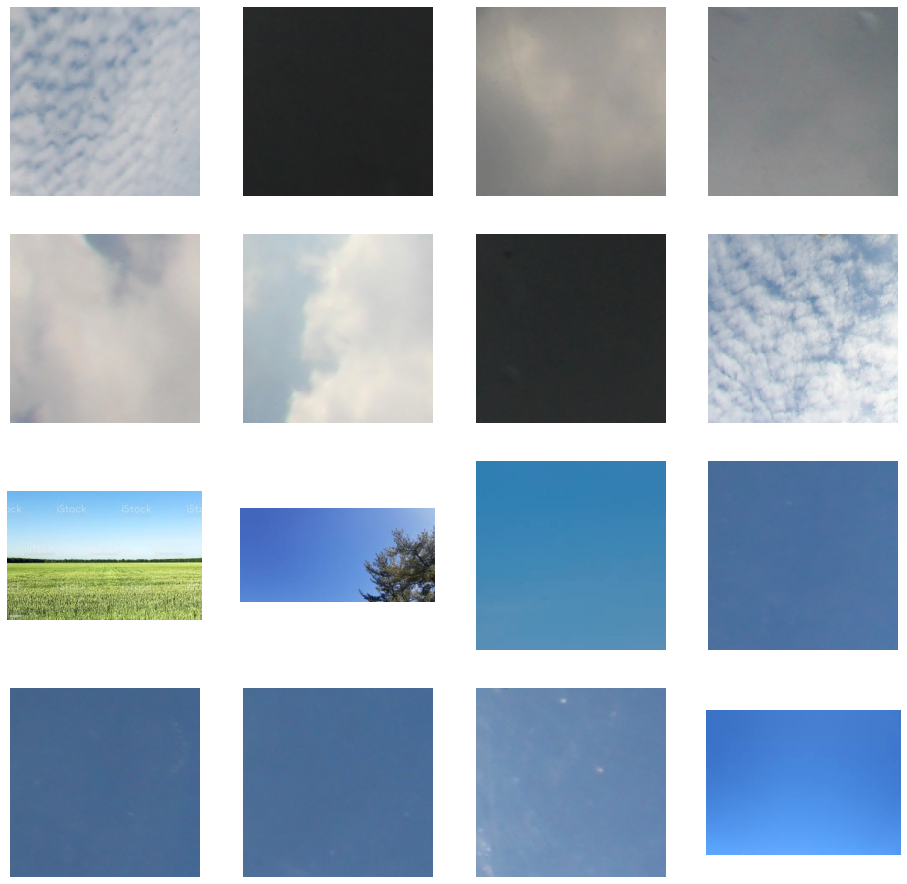

In [9]:
nrows=4
ncols=4
pic_index=0
fig = plt.gcf()
fig.set_size_inches(ncols*4,nrows*4)

pic_index =8
next_cat =[os.path.join(train_cats_dir, fname) for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog =[os.path.join(train_dogs_dir, fname) for fname in train_dog_fnames[pic_index-8:pic_index]]

for i , img_path in enumerate(next_cat+next_dog):
  sp=plt.subplot(nrows,ncols, i+1)
  sp.axis('Off')
  img=mpimg.imread(img_path)
  plt.imshow(img)

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Transfer Learning:

### Step 1: Data(Image) Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:
BATCH_SIZE = 3
IMG_SHAPE = 125

In [14]:
def plotImages(images_arr):
  fig, axis = plt.subplots(1,5, figsize=(20,20))
  axes = axis.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

In [15]:
image_gen_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range =0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [16]:
train_data_gen = image_gen_train.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory = train_dir,
    shuffle = True,
    target_size = (IMG_SHAPE,IMG_SHAPE),
    class_mode = 'binary'
)

Found 593 images belonging to 2 classes.


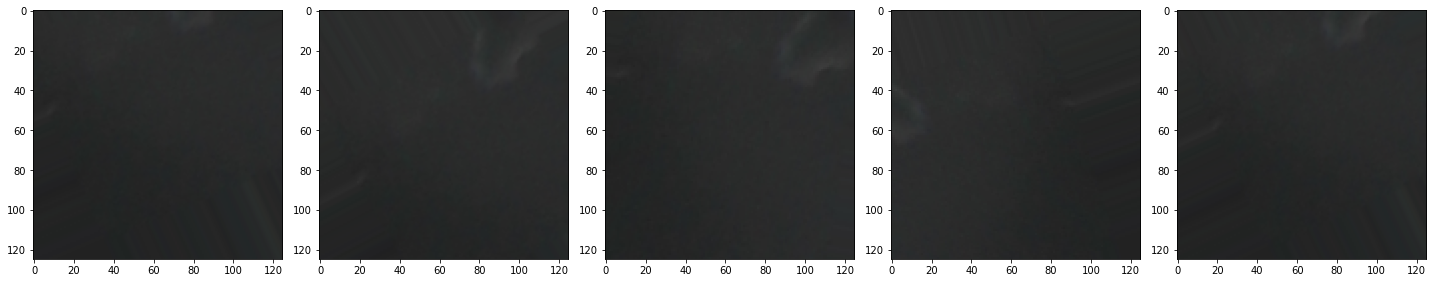

In [17]:
augmented_Im = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_Im)

In [18]:
image_gen_val = ImageDataGenerator(rescale = 1./255)

In [19]:
val_data_gen = image_gen_val.flow_from_directory(
     batch_size = BATCH_SIZE,
    directory = validation_dir,
    target_size = (IMG_SHAPE,IMG_SHAPE),
    class_mode = 'binary'
)

Found 80 images belonging to 2 classes.


In [20]:
INPUT_SHAPE = (125,125,3)

## Step 2, Load a PreTrained Model

In [21]:
from keras.applications import vgg16
import tensorflow as tf
import keras

In [22]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
vgg_model = Model(vgg.input,output)

58900480/58889256 [==============================] - 1s 0us/step


In [23]:
##not trainable because we are using weights from vgg16
vgg_model.trainable = False
for layer in vgg_model.layers:
  layer.trainable = False

In [24]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

In [25]:
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(512, activation='relu', input_dim=INPUT_SHAPE))
##model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 4608)              14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2359808   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 17,107,393
Trainable params: 2,392,705
Non-trainable params: 14,714,688
_________________________________________________________________


In [27]:
from tensorflow import keras
from tensorflow.keras import layers

In [28]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.007),
              metrics=['accuracy'])

In [29]:
history = model.fit(train_data_gen, epochs=20, validation_data=val_data_gen,
                              validation_steps=20, callbacks=[callback], verbose=2)

Epoch 1/20
198/198 - 38s - loss: 1.1796 - accuracy: 0.7369 - val_loss: 1.3920 - val_accuracy: 0.4833
Epoch 2/20
198/198 - 7s - loss: 0.2987 - accuracy: 0.9191 - val_loss: 0.6319 - val_accuracy: 0.7667
Epoch 3/20
198/198 - 7s - loss: 0.2454 - accuracy: 0.9342 - val_loss: 0.9166 - val_accuracy: 0.6667
Epoch 4/20
198/198 - 7s - loss: 0.2347 - accuracy: 0.9494 - val_loss: 0.2557 - val_accuracy: 0.9000
Epoch 5/20
198/198 - 7s - loss: 0.1857 - accuracy: 0.9562 - val_loss: 0.2323 - val_accuracy: 0.9000
Epoch 6/20
198/198 - 7s - loss: 0.1178 - accuracy: 0.9781 - val_loss: 0.3020 - val_accuracy: 0.9167
Epoch 7/20
198/198 - 7s - loss: 0.0979 - accuracy: 0.9747 - val_loss: 0.0427 - val_accuracy: 0.9833
Epoch 8/20
198/198 - 7s - loss: 0.1587 - accuracy: 0.9696 - val_loss: 0.5769 - val_accuracy: 0.8500
Epoch 9/20
198/198 - 7s - loss: 0.0848 - accuracy: 0.9831 - val_loss: 1.0827 - val_accuracy: 0.8167
Epoch 10/20
198/198 - 7s - loss: 0.1565 - accuracy: 0.9798 - val_loss: 2.5304 - val_accuracy: 0.566

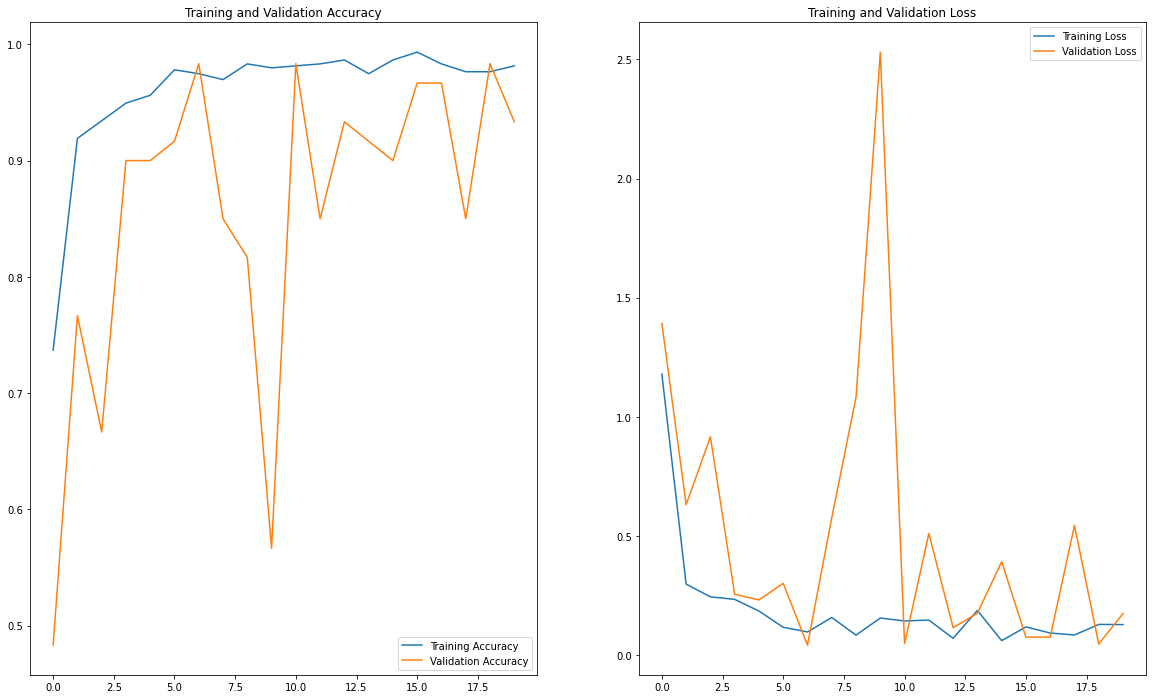

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
import tensorflow as tf

from tensorflow.keras.preprocessing import image


In [33]:
#Print the Target names



target_names = []

for key in val_data_gen.class_indices:

    target_names.append(key)



print(target_names)

['cloud', 'no_cloud']


In [35]:

# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



# confusion matrix
matrix = confusion_matrix(val_data_gen.classes, y_pred1, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(val_data_gen.classes, y_pred1,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(val_data_gen.classes, y_pred1)
print('Classification report : \n',matrix)

Confusion matrix : 
 [[ 0 40]
 [ 0 40]]
Outcome values : 
 0 40 0 40
Classification report : 
               precision    recall  f1-score   support

           0       0.50      1.00      0.67        40
           1       0.00      0.00      0.00        40

    accuracy                           0.50        80
   macro avg       0.25      0.50      0.33        80
weighted avg       0.25      0.50      0.33        80



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
img_path = "/content/E_6img.png"


In [ ]:
img = image.load_img(img_path, target_size=(125, 125))
plt.imshow(img)
plt.show()


In [ ]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [ ]:
prediction = model.predict(img_batch)
prediction

### second test image

In [ ]:
img_path1 = "/content/images244.png"


In [ ]:
img1 = image.load_img(img_path1, target_size=(125, 125))
plt.imshow(img1)
plt.show()

In [ ]:
img_array1 = image.img_to_array(img1)
img_batch1 = np.expand_dims(img_array1, axis=0)

In [ ]:
prediction1 = model.predict(img_batch1)
prediction1